In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
if not "milligrad" in os.listdir():
    os.chdir('..')

from milligrad import Tensor, Adam
from extras.mnist import load_mnist_data

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# one-hot encoding labels
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

# normalizing
mean, std = x_train.mean(), x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std

# pad to to 32 to be divisible by powers of 2
x_train, x_test = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), 'constant'), np.pad(x_test, ((0, 0), (2, 2), (2, 2)), 'constant')


ValueError: Failed to download train-images-idx3-ubyte.gz

In [ ]:
from milligrad import Tensor

class ConvNet2d:
    def __init__(self):
        self.k = Tensor.randn(1, 9, 9, 3)   
        self.w = Tensor.xavier(3 * 24 * 24, 10)
        self.b = Tensor.zeros(10)

        
    def __call__(self, x:Tensor)->Tensor:
        x = x.conv2d(self.k).relu()
        return x.reshape(-1, 3 * 24 * 24) @ self.w + self.b
        
    def parameters(self):
        return [self.k, self.w, self.b]
    
model = ConvNet2d()
model(Tensor.randn(9, 1, 32, 32)).shape

(9, 10)

In [ ]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128
LR = 1e-3
LAMBDA = 1e-4


model = ConvNet2d()
optim = Adam(model.parameters(), lr=LR)


shuffle = np.random.permutation(len(x_train))

losses = []
accuracies = []
accuracies_test = []
for i in tqdm(range(0, len(x_train)//BATCH_SIZE)):
    indices = shuffle[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    x = Tensor(x_train[indices][:, None])
    y = Tensor(y_train[indices])
    y_hat = model(x)
    
    loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()

    losses.append(loss.data)
    accuracies.append(accuracy(y.data, y_hat.data))
    accuracies_test.append(accuracy(y_test, model(Tensor(x_test[:, None])).data))
    
    optim.zero_grad()
    loss.backward()
    optim.step()
        
            

  0%|          | 1/468 [00:14<1:54:28, 14.71s/it]


KeyboardInterrupt: 

In [ ]:
from milligrad import topological_sort
[x._grad_fn for x in reversed(topological_sort(loss)) if x._grad_fn]

['-',
 '/',
 'sum',
 'sum',
 '*',
 'log_softmax',
 '+',
 '@',
 'reshape',
 'relu',
 'conv2d']

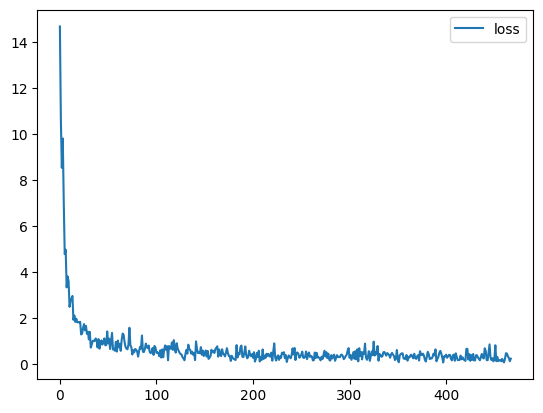

In [ ]:
plt.plot(losses, label='loss')
plt.legend()
plt.show()

In [ ]:
max(accuracies)

0.984375

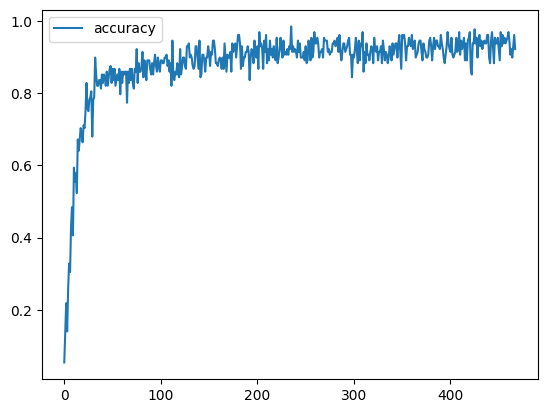

In [ ]:
plt.plot(accuracies, label='accuracy')
plt.legend()
plt.show()


In [ ]:

class ConvNet2d:
    def __init__(
            self, c_in:int, c_out:int, kernel_size:tuple[int,int], padding:tuple[int,int]=(0,0)
        ):
        self.kernel_size, self.padding = kernel_size, padding
        
        self.kernels = Tensor.randn(c_in, *kernel_size, c_out)
        self.bias = Tensor.randn(c_out, 1, 1)
        
    def __call__(self, x:Tensor)->Tensor:
        # (batch_size, c_in, w_i, h_i) -> (batch_size, c_out, w_o, h_o)
        return x.conv2d(self.kernel, self.padding) + self.bias
